In [11]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [12]:
# Load and parse annotations
def load_annotations(annotation_file):
    print(f"Loading annotations from {annotation_file}")
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    print(f"Loaded {len(annotations['annotations'])} annotations")
    return annotations

def parse_keypoints(annotations, label):
    data = []
    for ann in annotations['annotations']:
        keypoints = ann['keypoints']
        keypoints_array = np.array(keypoints).reshape(-1, 3)
        coords = keypoints_array[:, :2]
        visibility = keypoints_array[:, 2]
        data.append((coords, visibility, label))
    print(f"Parsed {len(data)} keypoints with label {label}")
    return data

# Load annotations
correct_annotations = load_annotations('annotations_v3/n6-269-299-correct.json')
incorrect_annotations = load_annotations('annotations_v3/lumbar-neth-K-1.1-285-w53445.json')

# Parse keypoints
correct_data = parse_keypoints(correct_annotations, label=1)
incorrect_data = parse_keypoints(incorrect_annotations, label=0)

# Combine and split data
all_data = correct_data + incorrect_data
print(f"Total data points: {len(all_data)}")
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42)
print(f"Training data points: {len(train_data)}, Validation data points: {len(val_data)}")


Loading annotations from annotations_v3/n6-269-299-correct.json
Loaded 300 annotations
Loading annotations from annotations_v3/lumbar-neth-K-1.1-285-w53445.json
Loaded 286 annotations
Parsed 300 keypoints with label 1
Parsed 286 keypoints with label 0
Total data points: 586
Training data points: 468, Validation data points: 118


In [13]:
# Define custom dataset
class PoseDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        coords, visibility, label = self.data[idx]
        coords_tensor = torch.tensor(coords, dtype=torch.float)
        visibility_tensor = torch.tensor(visibility, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.long)
        # Define edge_index for the pose graph
        edge_index = torch.tensor([
            [0, 1], [1, 0],  # nose - left eye
            [0, 2], [2, 0],  # nose - right eye
            [1, 3], [3, 1],  # left eye - left ear
            [2, 4], [4, 2],  # right eye - right ear
            [5, 6], [6, 5],  # left shoulder - right shoulder
            [5, 7], [7, 5],  # left shoulder - left elbow
            [6, 8], [8, 6],  # right shoulder - right elbow
            [7, 9], [9, 7],  # left elbow - left wrist
            [8, 10], [10, 8],  # right elbow - right wrist
            [5, 11], [11, 5],  # left shoulder - left hip
            [6, 12], [12, 6],  # right shoulder - right hip
            [11, 12], [12, 11],  # left hip - right hip
            [11, 13], [13, 11],  # left hip - left knee
            [12, 14], [14, 12],  # right hip - right knee
            [13, 15], [15, 13],  # left knee - left ankle
            [14, 16], [16, 14],  # right knee - right ankle
        ], dtype=torch.long).t().contiguous()
        return Data(x=coords_tensor, edge_index=edge_index, y=label_tensor)

# Create datasets
train_dataset = PoseDataset(train_data)
val_dataset = PoseDataset(val_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [14]:
# Define the original GCN model
class PoseGCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(PoseGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.linear = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, data.batch)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


In [15]:
# Define the deep GCN model
class DeepPoseGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels=64, num_classes=2):
        super(DeepPoseGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels, hidden_channels//2)
        self.linear2 = torch.nn.Linear(hidden_channels//2, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = F.dropout(x2, p=0.2, training=self.training)
        x2 = x2 + x1
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = F.dropout(x3, p=0.2, training=self.training)
        x3 = x3 + x2
        x4 = self.conv4(x3, edge_index)
        x = global_mean_pool(x4, data.batch)
        x = F.relu(self.linear1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)


In [16]:
# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    predictions = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            pred = output.max(1)[1]
            correct += pred.eq(data.y).sum().item()
            predictions.extend(pred.cpu().numpy())
            labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return total_loss / len(loader), accuracy, precision, recall, f1


In [17]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100
criterion = torch.nn.CrossEntropyLoss()

# Initialize metrics storage
original_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
deep_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Train original GCN
model = PoseGCN(num_node_features=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    print(f"Training Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, val_loader, criterion, device)
    original_metrics['accuracy'].append(val_acc)
    original_metrics['precision'].append(val_prec)
    original_metrics['recall'].append(val_rec)
    original_metrics['f1'].append(val_f1)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Prec: {val_prec:.4f}, Val Rec: {val_rec:.4f}, Val F1: {val_f1:.4f}')

# Train deep GCN
deep_model = DeepPoseGCN(num_node_features=2).to(device)
deep_optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    print(f"Training Deep Model Epoch {epoch+1}/{num_epochs}")
    train_loss = train(deep_model, train_loader, deep_optimizer, criterion, device)
    val_loss, val_acc, val_prec, val_rec, val_f1 = validate(deep_model, val_loader, criterion, device)
    deep_metrics['accuracy'].append(val_acc)
    deep_metrics['precision'].append(val_prec)
    deep_metrics['recall'].append(val_rec)
    deep_metrics['f1'].append(val_f1)
    print(f'Deep Model Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Prec: {val_prec:.4f}, Val Rec: {val_rec:.4f}, Val F1: {val_f1:.4f}')


Training Epoch 1/100
Epoch 1/100, Train Loss: 2.1401, Val Loss: 0.8770, Val Acc: 0.5508, Val Prec: 0.5765, Val Rec: 0.7424, Val F1: 0.6490
Training Epoch 2/100
Epoch 2/100, Train Loss: 1.2800, Val Loss: 0.9862, Val Acc: 0.5593, Val Prec: 0.5593, Val Rec: 1.0000, Val F1: 0.7174
Training Epoch 3/100
Epoch 3/100, Train Loss: 1.3289, Val Loss: 0.7867, Val Acc: 0.5678, Val Prec: 0.5641, Val Rec: 1.0000, Val F1: 0.7213
Training Epoch 4/100
Epoch 4/100, Train Loss: 1.0904, Val Loss: 0.8220, Val Acc: 0.5000, Val Prec: 0.6296, Val Rec: 0.2576, Val F1: 0.3656
Training Epoch 5/100
Epoch 5/100, Train Loss: 1.0162, Val Loss: 0.7103, Val Acc: 0.5254, Val Prec: 0.5862, Val Rec: 0.5152, Val F1: 0.5484
Training Epoch 6/100
Epoch 6/100, Train Loss: 0.9832, Val Loss: 0.7196, Val Acc: 0.5339, Val Prec: 0.6410, Val Rec: 0.3788, Val F1: 0.4762
Training Epoch 7/100
Epoch 7/100, Train Loss: 0.7874, Val Loss: 0.6921, Val Acc: 0.5339, Val Prec: 0.5797, Val Rec: 0.6061, Val F1: 0.5926
Training Epoch 8/100
Epoch 

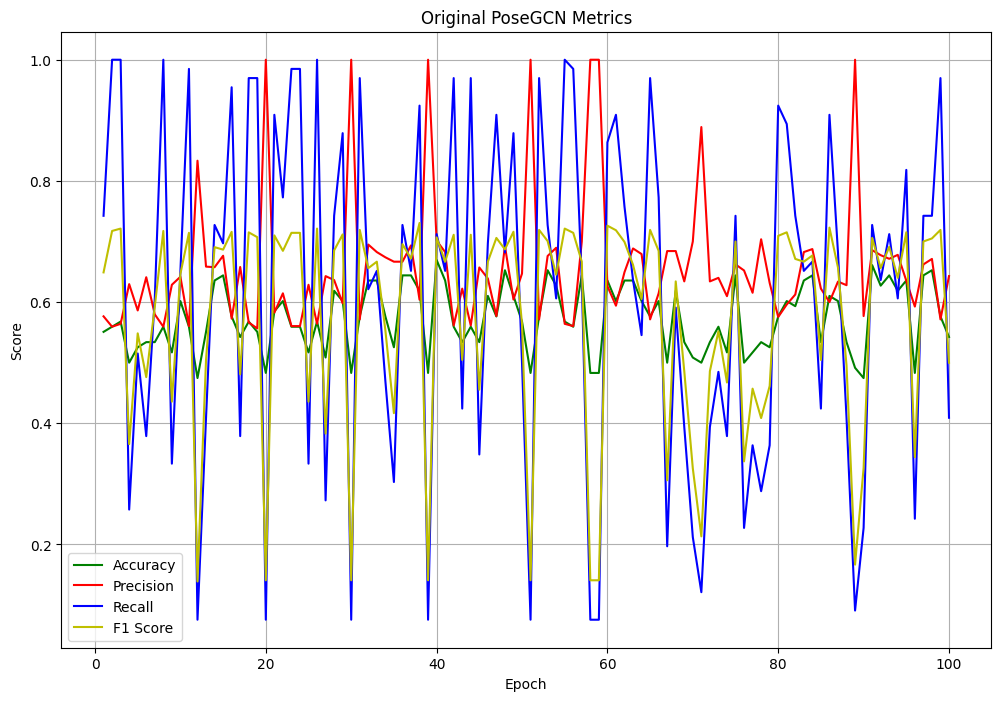

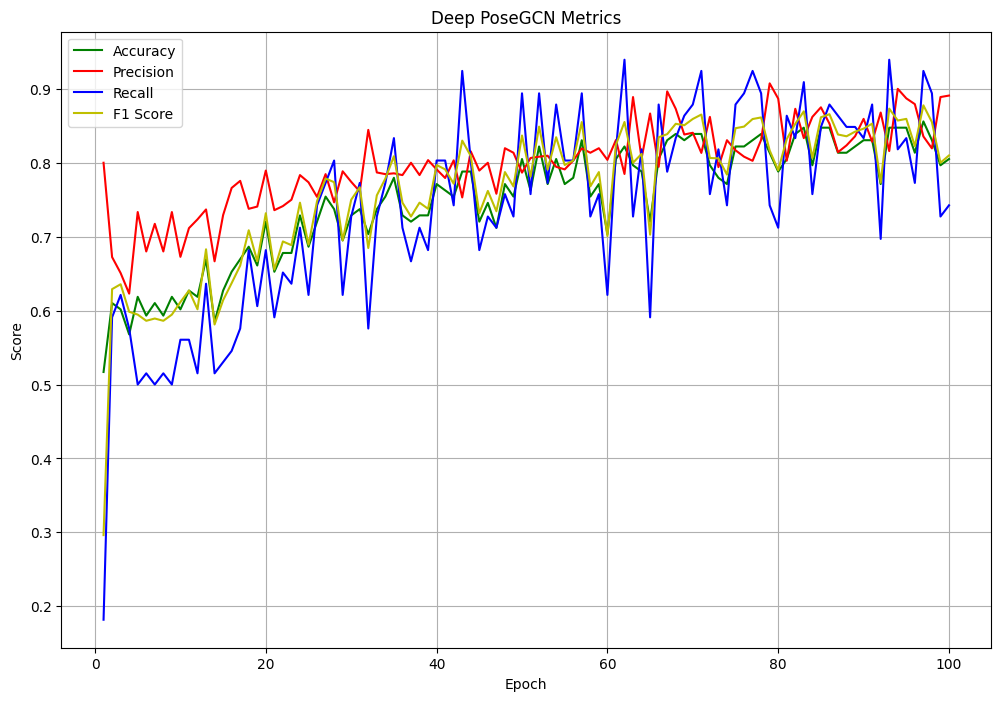

In [18]:
# Plot metrics
def plot_metrics(metrics, title, save_path):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics['accuracy']) + 1)
    plt.plot(epochs, metrics['accuracy'], 'g-', label='Accuracy')
    plt.plot(epochs, metrics['precision'], 'r-', label='Precision')
    plt.plot(epochs, metrics['recall'], 'b-', label='Recall')
    plt.plot(epochs, metrics['f1'], 'y-', label='F1 Score')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# Plot metrics for original model
plot_metrics(original_metrics, 'Original PoseGCN Metrics', 'original_posegcn_metrics.png')

# Plot metrics for deep model
plot_metrics(deep_metrics, 'Deep PoseGCN Metrics', 'deep_posegcn_metrics.png')


In [19]:
# Compare models
print("\n=== Model Comparison ===")
print(f"Original PoseGCN - Best F1: {max(original_metrics['f1']):.4f}")
print(f"DeepPoseGCN - Best F1: {max(deep_metrics['f1']):.4f}")

# Add comparison of best precision, recall, and accuracy values
print("\n=== Best Precision, Recall, Accuracy Comparison ===")
print(f"Original PoseGCN - Best Precision: {max(original_metrics['precision']):.4f}")
print(f"DeepPoseGCN - Best Precision: {max(deep_metrics['precision']):.4f}")
print(f"Original PoseGCN - Best Recall: {max(original_metrics['recall']):.4f}")
print(f"DeepPoseGCN - Best Recall: {max(deep_metrics['recall']):.4f}")
print(f"Original PoseGCN - Best Accuracy: {max(original_metrics['accuracy']):.4f}")
print(f"DeepPoseGCN - Best Accuracy: {max(deep_metrics['accuracy']):.4f}")



=== Model Comparison ===
Original PoseGCN - Best F1: 0.7305
DeepPoseGCN - Best F1: 0.8777

=== Best Precision, Recall, Accuracy Comparison ===
Original PoseGCN - Best Precision: 1.0000
DeepPoseGCN - Best Precision: 0.9074
Original PoseGCN - Best Recall: 1.0000
DeepPoseGCN - Best Recall: 0.9394
Original PoseGCN - Best Accuracy: 0.6695
DeepPoseGCN - Best Accuracy: 0.8559
